In [1]:
"""
    Get cleaned data
"""

import numpy as np

dataset = np.load('./datasets/Power_per_bandRNN.npy')
labels = np.load('./datasets/labels.npy')
print(dataset.shape)
print(labels.shape)

(889, 60, 20)
(889,)


In [2]:
"""
    Split dataset
"""

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

flatten_dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], dataset.shape[2], 1)

shuf_dataset, shuf_labels = shuffle(flatten_dataset, labels)
X_train, X_test, y_train, y_test = train_test_split(shuf_dataset, shuf_labels, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
print("Train set size: {}, Val set size: {}, Test set size: {}".format(len(X_train), len(X_val), len(X_test)))
print(y_train.shape)
print(X_train.shape)

Train set size: 622, Val set size: 134, Test set size: 133
(622,)
(622, 60, 20, 1)


In [8]:
"""
    Model and train
"""

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, SpatialDropout2D
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Reshape, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model_path = './models/'
json_name = 'CRNN_Power.json'
weight_name = 'CRNN_Power_tmp.h5'

batch_size = 16
epochs = 128
num_classes = 2

print("Constructing MLP Model: ...", end='')
model = Sequential() # input (None, 60, 20, 1)
model.add(Conv2D(16, kernel_size=4, padding='same', input_shape= X_train.shape[1:])) # (None, 60, 20, 16)
model.add(Activation('relu'))
model.add(Conv2D(16, kernel_size=4, padding='same')) # (None, 60, 20, 16)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))# (None, 60, 10, 16)
model.add(SpatialDropout2D(rate=0.01))

model.add(Conv2D(32, kernel_size=4, padding='same')) # (None, 60, 10, 32)
model.add(Activation('relu'))
model.add(Conv2D(32, kernel_size=4, padding='same')) # (None, 60, 10, 32)
model.add(Activation('relu'))
model.add(Dropout(rate=0.01))

#model.summary()

# convert to RNN
model.add(Reshape(target_shape=(60, -1)))
model.add(Dense(32))
model.add(Activation('relu'))

model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.05))
model.add(Dense(1, activation='sigmoid'))
print(" Complete.")

print("Compiling MLP Model: ...", end='')
optimizer = Adam(lr=0.001)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
print(" Complete.")

earlyStop = EarlyStopping(monitor='val_loss', patience=32, mode='min')
mcp_save = ModelCheckpoint(filepath=model_path+weight_name, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

print("Fitting MLP Model: ...")
results = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[earlyStop, mcp_save, reduce_lr_loss], validation_data=(X_val, y_val), shuffle=True)
print("Complete.")

Constructing MLP Model: ... Complete.
Compiling MLP Model: ... Complete.
Fitting MLP Model: ...
Train on 622 samples, validate on 134 samples
Epoch 1/128
622/622 [==============================] - 9s 15ms/step - loss: 0.6625 - acc: 0.6367 - val_loss: 0.5565 - val_acc: 0.7463
Epoch 2/128
622/622 [==============================] - 7s 12ms/step - loss: 0.5207 - acc: 0.7846 - val_loss: 0.4116 - val_acc: 0.7910
Epoch 3/128
622/622 [==============================] - 8s 12ms/step - loss: 0.4307 - acc: 0.8135 - val_loss: 0.4060 - val_acc: 0.8134
Epoch 4/128
622/622 [==============================] - 7s 12ms/step - loss: 0.3718 - acc: 0.8521 - val_loss: 0.3326 - val_acc: 0.8507
Epoch 5/128
622/622 [==============================] - 8s 13ms/step - loss: 0.3821 - acc: 0.8424 - val_loss: 0.3585 - val_acc: 0.8284
Epoch 6/128
622/622 [==============================] - 9s 14ms/step - loss: 0.3486 - acc: 0.8601 - val_loss: 0.2793 - val_acc: 0.9104
Epoch 7/128
622/622 [==============================] -

In [9]:
"""
    Save the model
"""

model_path = './models/'
json_name = 'CRNN_Power.json'
weight_name = 'CRNN_Power.h5'

model_json = model.to_json()
with open(model_path+json_name, 'w') as json_file:
    json_file.write(model_json)
#model.save_weights(model_path+weight_name)

133/133 [==============================] - 0s 3ms/step

Final test acc: 93.98%


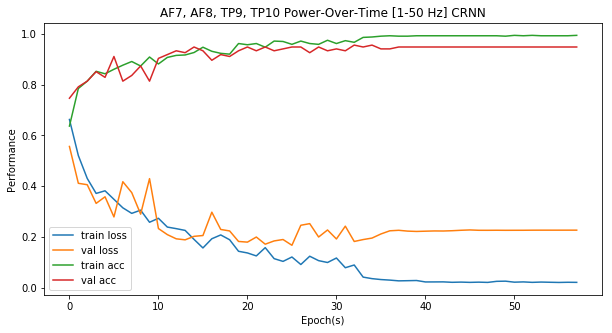

In [12]:
"""
    Output & plot the results
    Aspect Ratio 2 to 1
"""

import matplotlib.pyplot as plt

image_path = './graphs/'
image_name = 'CRNN_Power_2to1.png'

fig = plt.figure(figsize=(10,5))
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.plot(results.history['acc'], label='train acc')
plt.plot(results.history['val_acc'], label='val acc')
#plt.ylim((0.05,1.05))
plt.legend(loc='lower left')
plt.title('AF7, AF8, TP9, TP10 Power-Over-Time [1-50 Hz] CRNN')
plt.xlabel('Epoch(s)')
plt.ylabel('Performance')
#plt.show()
plt.savefig(image_path+image_name, bbox_inches='tight')
test_scores = model.evaluate(X_test, y_test)
print("\nFinal test %s: %.2f%%" % (model.metrics_names[1], test_scores[1]*100))

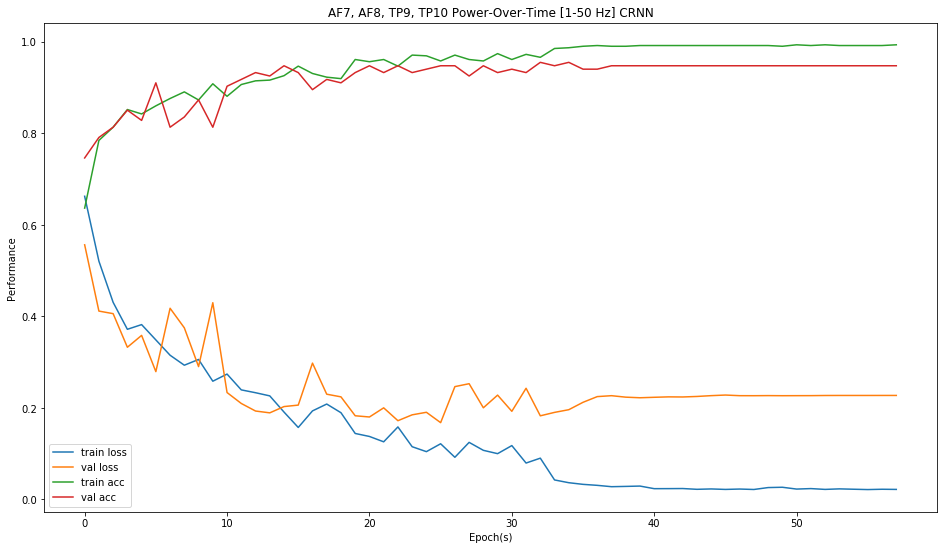

In [11]:
"""
    Output & plot the results
    Aspect Ratio 2 to 1
"""

import matplotlib.pyplot as plt

image_path = './graphs/'
image_name = 'CRNN_Power_16to9.png'

fig = plt.figure(figsize=(16,9))
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.plot(results.history['acc'], label='train acc')
plt.plot(results.history['val_acc'], label='val acc')
plt.legend(loc='lower left')
plt.title('AF7, AF8, TP9, TP10 Power-Over-Time [1-50 Hz] CRNN')
plt.xlabel('Epoch(s)')
plt.ylabel('Performance')
#plt.show()
plt.savefig(image_path+image_name, bbox_inches='tight')

In [13]:
"""
    Try fetching the model
"""

from keras.models import model_from_json

model_path = './models/'
json_name = 'CRNN_Power.json'
weight_name = 'CRNN_Power.h5'

json_file = open(model_path+json_name)
loaded_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_json)
loaded_model.load_weights(model_path+weight_name)
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

loaded_test_score = model.evaluate(X_test, y_test)
print("\nFinal test %s: %.2f%%" % (loaded_model.metrics_names[1], loaded_test_score[1]*100))

133/133 [==============================] - 1s 5ms/step

Final test acc: 93.98%
